# NEMO Example 

For this example, the NEMO output files have already been saved as netCDF with the right coordinate names. The [xnemogcm](https://github.com/rcaneill/xnemogcm) package is designed to open NEMO datasets so they are understandable by xgcm.

Below are some example of how to make calculations using xgcm.

First we import xarray and xgcm:

In [1]:
import xarray as xr
import numpy as np
import xgcm
from matplotlib import pyplot as plt

xr.set_options(display_expand_attrs=False, display_expand_data=False)

%matplotlib inline
plt.rcParams['figure.figsize'] = (4,5)

In [48]:
xgcm.__version__

'0.8.1'

Now we open the NEMO example dataset, from the BASIN configuration.

We get a dataset produced for the purpose of this documentation, as the time average of the reference run of the paper 
The Polar Transition from Alpha to Beta Regions Set by a Surface Buoyancy Flux Inversion, [Caneill et al 2022, JPO](https://doi.org/10.1175/JPO-D-21-0295.1)


Link to the dataset: [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7795560.svg)](https://doi.org/10.5281/zenodo.7795560)

In [3]:
# download the data
import urllib.request
import shutil
from pathlib import Path

url = 'https://zenodo.org/record/7795560/files/nemo_dataset.nc'
name = 'nemo_dataset.nc'
path = Path('nemo_idealized_data/')
path.mkdir(parents=True, exist_ok=True)

with urllib.request.urlopen(url) as response, open(path/name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

# open the data
ds = xr.open_dataset(path/name)

for i in ds:
    if i[0] == 'g':
        ds.coords[i] = ds[i]        
        
ds

<xarray.Dataset>
Dimensions:        (z_c: 36, axis_nbounds: 2, y_c: 79, x_c: 42, x_f: 42,
                    y_f: 79, z_f: 36)
Coordinates: (12/18)
  * z_c            (z_c) int64 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34 35
  * x_c            (x_c) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40 41
  * y_c            (y_c) int64 0 1 2 3 4 5 6 7 8 ... 70 71 72 73 74 75 76 77 78
    gdept_1d       (z_c) float64 ...
  * x_f            (x_f) float64 0.5 1.5 2.5 3.5 4.5 ... 38.5 39.5 40.5 41.5
  * y_f            (y_f) float64 0.5 1.5 2.5 3.5 4.5 ... 75.5 76.5 77.5 78.5
    ...             ...
    gphit          (y_c, x_c) float64 ...
    gphiu          (y_c, x_f) float64 ...
    gphiv          (y_f, x_c) float64 ...
    gphif          (y_f, x_f) float64 ...
    gdept_0        (z_c, y_c, x_c) float64 ...
    gdepw_0        (z_f, y_c, x_c) float64 ...
Dimensions without coordinates: axis_nbounds
Data variables: (12/46)
    deptht_bounds  (z_c, axis_nbounds) float32 ...
    e3t            (z_c, y_c, x_c) float32 ...
    thetao         (z_c, y_c, x_c) float32 ...
    so             (z_c, y_c, x_c) float32 ...
    tos            (y_c, x_c) float32 ...
    zos            (y_c, x_c) float32 ...
    ...             ...
    hv_0           (y_f, x_c) float64 ...
    tmask          (z_c, y_c, x_c) int8 ...
    umask          (z_c, y_c, x_f) int8 ...
    vmask          (z_c, y_f, x_c) int8 ...
    fmask          (z_c, y_f, x_f) int8 ...
    mbathy         (y_c, x_c) int32 ...

In [4]:
# In this configuration, the model is symmetric at the equator. For simplicity, we remove the southern bondaries for thi example:
ds['tmask'] = ds.tmask.where(ds.y_c > 0, 0)
ds['umask'] = ds.umask.where(ds.y_c > 0, 0)
ds['vmask'] = ds.vmask.where(ds.y_f > 0, 0)
ds['fmask'] = ds.fmask.where(ds.y_f > 0, 0)

In the coordinates, the *_c* suffix means *center* while the *_f* suffix means *face*. Thus the (x_c, y_c, z_c) point is the T point, the (x_c, y_f, z_c) is the V point, etc.

## Geometry of the basin
The geometry of the simulation is a closed basin, with a bottom bathymetry, going from 2000 m at the coasts, to 4000 m in the interior of the basin. Terrain following coordinates are used and the free surface is linear (fixed vertical levels).
A 2 degrees Mercator grid is used.

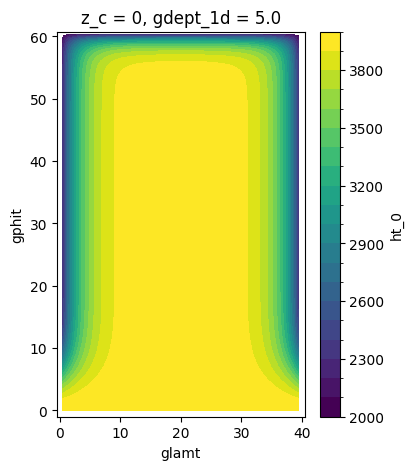

In [5]:
ds.ht_0.where(ds.tmask.isel(z_c=0)).plot.contourf(x='glamt', y='gphit', vmin=2000, vmax=4000, levels=21)

## Creating the grid object

Next we create a `Grid` object from the dataset.
All the axes are here non-periodic.
The `metrics` dict contains the scale factors.

In [6]:

metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
}
grid = xgcm.Grid(ds, metrics=metrics, periodic=False)
print(grid)

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   y_c --> right
  * right    y_f --> center
Z Axis (not periodic, boundary=None):
  * center   z_c --> left
  * left     z_f --> center
X Axis (not periodic, boundary=None):
  * center   x_c --> right
  * right    x_f --> center


We see that xgcm identified for different axes: X (longitude), Y (latitude), Z (depth). There is no time, as the dataset we use has been already time averaged.

## Computation examples
### Horizontal gradient of SST

We will compute the horizontal component of the gradient of SST in the longitude
direction as a first example to understand the logic behind the
xgcm grids.

We want to compute
$\frac{\partial SST}{\partial x}$.
The SST is the variable `tos` (Temperature Ocean Surface) in our dataset.

In discrete form, using the NEMO notation, the derivative becomes [1]

$$\frac{\partial SST}{\partial x} = \frac{1}{e_{1u}} \delta_{i+1/2} SST
= \frac{1}{e_{1u}} (SST_{i+1} - SST_i) \ .$$

The last T point is an earth point here, such as the 2 last U points: we set up the
`boundary` argument to 'fill' and the fill value to zero (this value does not play an important role here, as we fill earth points).

The gradient is first computed with the `diff` function and
then with the `derivative` function, the result is the same as the `derivative`
function is aware of which scale factor to use.

<hr>
[1] NEMO book v4.0.1, pp 22

In [7]:
sst = ds.tos

grad_T_lon0 = grid.diff(sst, axis='X', boundary='fill', fill_value=0) / ds.e1u
grad_T_lon1 = grid.derivative(sst, axis='X', boundary='fill', fill_value=0)
print(grad_T_lon1.coords)

assert np.allclose(grad_T_lon0, grad_T_lon1)

Coordinates:
  * y_c      (y_c) int64 0 1 2 3 4 5 6 7 8 9 ... 69 70 71 72 73 74 75 76 77 78
  * x_f      (x_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 37.5 38.5 39.5 40.5 41.5


As expected the result of the 2 operations is the same.
The position of the derivative is now on the U point.

### Divergence Calculation

Here we show how to calculate the divergence of the flow.
The precise details of how to do this calculation are highly model- and configuration-dependent (e.g. free-surface vs. rigid lid, etc.)
In this example, the flow is incompressible, without precipitations
or evaporation, with a linear free surface, satisfying the continuity equation

$$ \vec{\nabla} \cdot \vec{u} = 
  \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}
  + \frac{\partial w}{\partial z} = 0 \ .$$
  
In non-linear free surface, the divergence of $\vec{u}$ is not 0 anymore, it is linked to
the time variation of the $e_{3}$ scale factors.

In discrete form, using NEMO notation, the equation becomes [1]

$$ \vec{\nabla} \cdot \vec{u} = \frac{1}{e_{1t}e_{2t}e_{3t}} \left[
  \delta_i(u \cdot e_{2u} \cdot e_{3u})
  + \delta_j(v \cdot e_{1v} \cdot e_{3v}) \right]
  + \frac{1}{e_{3t}} \delta_k(w)  \ .$$

The equation for the divergence calculation could be simplified due to the geometry of our basin, but we will keep it in the general form.

<hr>
[1] NEMO book v4.0.1, pp 22

#### 3d flow

The first T point along x is an earth point, we can use a 'fill' `boundary` with a 0 `fill_value`. The same argument applies along y and z.

&#x26A0; We need to use a negative sign for the vertical derivative, as the k-axis increases with depth.

&#x26A0; If the model is ran without linear free surface the e3 scale factors are not constant in time, we need to take the e3t and not e3t_0 (and similar for e3u, e3v, e3f). The data are are "thickness weighted".

In [8]:
bd={'boundary':'fill', 'fill_value':0}

div_uv = (
    grid.diff(ds.uo * ds.e2u * ds.e3u, 'X', **bd) / (ds.e1t * ds.e2t * ds.e3t)
    + grid.diff(ds.vo * ds.e1v * ds.e3v, 'Y', **bd) / (ds.e1t * ds.e2t * ds.e3t)
).where(ds.tmask)

div_w = - grid.diff(ds.woce, 'Z', **bd) / ds.e3t

div_uvw = div_uv + div_w
np.abs(div_uvw).max()

<xarray.DataArray ()>
6.281e-11

As expected the divergence of the flow is zero (if we neglect the truncation error).

#### Vertical velocity

In NEMO the vertical velocity is computed from the divergence of the horizontal velocity.
In non-linear free surface, the vertical velocity can't be computed offline because it also takes the time
variations of the vertical scale factors into account.
However, we are using here a linear free surface, so that

$$
w(z) = \int_{bottom}^z \vec{\nabla}_h \cdot \vec{u} \, \text{d}z' 
= \int_{surf}^z \vec{\nabla}_h \cdot \vec{u} \, \text{d}z' - \int_{surf}^{bottom} \vec{\nabla}_h \cdot \vec{u} \, \text{d}z' \ .
$$

This is written in discrete form

$$
w(n) = \sum_0^n \left(\vec{\nabla}_h \cdot \vec{u}(k)\right)  e_{3t}(k)
- \sum_0^{n_{bot}} \left(\vec{\nabla}_h \cdot \vec{u}(k)\right)  e_{3t}(k) \ .
$$

We use the `grid.cumint` to perform the integration, and then we remove the total integral.

In [9]:
w = grid.cumint((div_uv), axis='Z', boundary='fill', fill_value=0) # integral from top
w = w - w.isel({'z_f':-1}) # now from bot

We now compare the computed vertical velocity with the one outputed by the model, at the bottom of the uper grid cell.

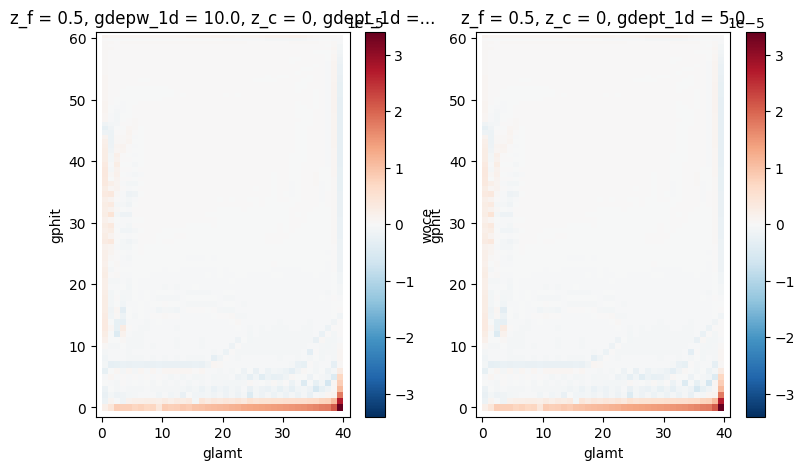

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(9,5))
ds.woce.where(ds.tmask.isel(z_c=0)).isel({'z_f':1}).plot(ax=ax[0], x='glamt', y='gphit')
w.where(ds.tmask.isel(z_c=0)).isel({'z_f':1}).plot(ax=ax[1], x='glamt', y='gphit')

The 2 fields look similar, which is confirmed by computing the difference.

In [11]:
abs((w - ds.woce).where(ds.tmask.isel(z_c=0))).max().compute()

<xarray.DataArray ()>
4.189e-09
Coordinates:
    z_c       int64 0
    gdept_1d  float64 5.0

### Vorticity
Here we compute more derived quantities from the velocity field.

The vertical component of the vorticity is a fundamental quantity of interest in ocean circulation theory. It is defined as

$$ \zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} \ . $$

The NEMO discretization is [1]

$$
\zeta = \frac{1}{e_{1f} e_{2f}} \left[\delta_{i+1/2}(v \cdot e_{2v}) - \delta_{j+1/2}(u \cdot e_{1u}) \right] 
$$

<hr>
[1] NEMO book v4.0.1, pp 22
<hr>

In xgcm, we calculate this quantity as

In [12]:
zeta = 1/(ds.e1f*ds.e2f) * (grid.diff(ds.vo*ds.e2v, 'X', **bd) - grid.diff(ds.uo*ds.e1u, 'Y', **bd)) * ds.fmask
zeta.dims

('y_f', 'x_f', 'z_c')

$\zeta$ is located in the F point (*x_f*, *y_f*, *z_c*).

We want to plot the vertical integral of this quantity, i.e. the barotropic vorticity, but before we need to have an estimate of `e3f`:

In [13]:
ds['e3f'] = grid.interp(ds.e3u, 'Y', boundary='extend')

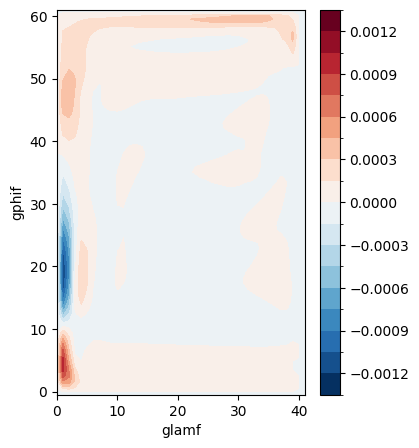

In [14]:
zeta_bt = (zeta * ds.e3f).sum(dim='z_c')
zeta_bt.plot.contourf(
    x='glamf', y='gphif', levels=21
)

### Barotropic Transport Streamfunction

We can use the barotropic velocity to calcuate the barotropic transport streamfunction, defined via

$$ u_{bt} = - \frac{\partial \Psi}{\partial y} \ , \ \ v_{bt} = \frac{\partial \Psi}{\partial x} \ .$$

$$ \Psi(x,y) = \int_0^x \int_{bottom}^{surface} v_{bt}(x,y) \, \text{d}z \, \text{d}x $$

We calculate this by integrating $v_{bt}$ along the X axis using the grid object's `cumint` method:

Coordinates:
  * x_f      (x_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 37.5 38.5 39.5 40.5 41.5
  * y_f      (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 74.5 75.5 76.5 77.5 78.5
    glamf    (y_f, x_f) float64 0.0 1.0 2.0 3.0 4.0 ... 37.0 38.0 39.0 40.0 41.0
    gphif    (y_f, x_f) float64 -0.5 -0.5 -0.5 -0.5 ... 61.01 61.01 61.01 61.01


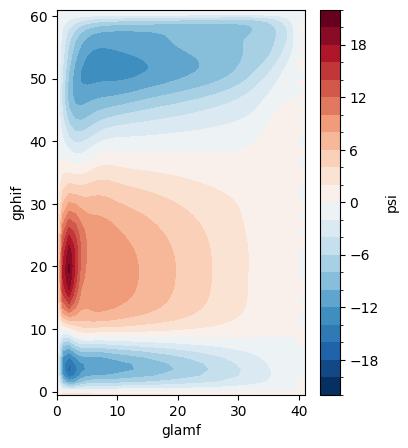

In [33]:
ds['psi'] = grid.cumint(grid.integrate(ds.vo, 'Z'),'X', **bd) * 1e-6
print(ds.psi.coords)
ds.psi.plot.contourf(
    x='glamf', y='gphif', levels=25
)

By construction, $\psi$ is 0 at the western boundary.

### Kinetic Energy

Finally, we plot the surface kinetic energy $1/2 (u^2 + v^2)$ by interpoloting both quantities the cell center point.

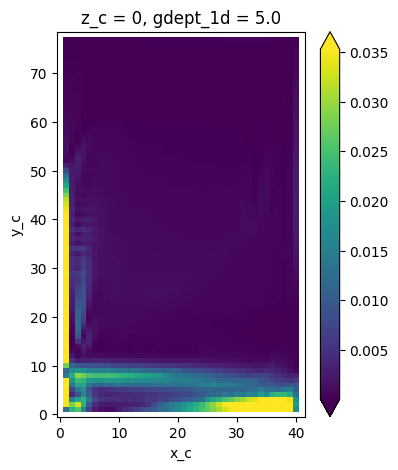

In [18]:
# an example of calculating kinetic energy
ke = 0.5*(grid.interp((ds.uo)**2, 'X', **bd) + grid.interp((ds.vo)**2, 'Y', **bd))
ke.where(ds.tmask).isel(z_c=0).plot(robust=True)

### Potential vorticity

We compute potential vorticity $qv = (\zeta + f) \cdot N^2$ on the F point.

We have already computed the potential vorticity, the planetary vorticity is outputed by NEMO.
We need to compute $N^2 = -\frac{g}{\rho_0} \frac{\partial \rho}{\partial z}$ and interpolate it on the F point.

In [19]:
# Comment: the NEMO run used here is using a simplified non-linear equation of state,
# ln_seos = .true. in namelist &nameos
# gsw.sigma0 should be used for NEMO runs that use the TEOS-10 equation of state

rn_a0, rn_b0, rn_lambda1 = 1.655e-1, 7.6554e-1, 0.06

def sigma0(T, S):
    """
    Compute the density using the simplified EOS
    """
    Ta, Sa = T - 10, S - 35
    return 26 - rn_a0 * (1 + 0.5 * rn_lambda1 * Ta) * Ta + rn_b0 * Sa

ds['sigma0'] = sigma0(ds.so, ds.thetao)

In [20]:
g = 9.81
rho0 = 1026

N2 = -g/rho0 * (-grid.derivative(ds.sigma0, 'Z', boundary='extend'))
# We have an extra minus sign in the derivative as the Z axis is oriented downward in NEMO

qv = (zeta + ds.ff_f) * grid.interp(N2, ['X', 'Y', 'Z'], boundary='extend')
qv

<xarray.DataArray (y_f: 79, x_f: 42, z_c: 36)>
1.319e-12 2.52e-12 2.39e-11 9.742e-11 1.771e-10 ... 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * x_f       (x_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 37.5 38.5 39.5 40.5 41.5
  * y_f       (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 74.5 75.5 76.5 77.5 78.5
    glamf     (y_f, x_f) float64 0.0 1.0 2.0 3.0 4.0 ... 38.0 39.0 40.0 41.0
    gphif     (y_f, x_f) float64 -0.5 -0.5 -0.5 -0.5 ... 61.01 61.01 61.01 61.01
  * z_c       (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
    gdept_1d  (z_c) float64 ...

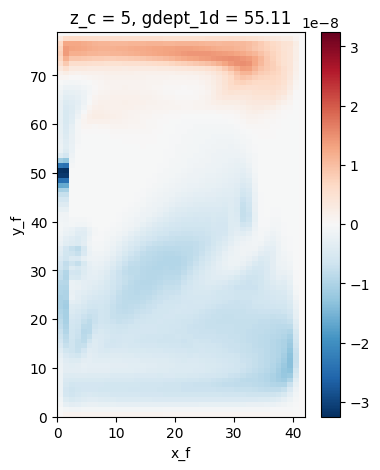

In [21]:
qv.isel(z_c=5).plot()

## The `transform` function

It is possible whith xgcm to remap variables from one coordinate to another (e.g. remap the velocities into density coordinates to compute the meridional overturning streamfunction in density coordinates).

We will show here 2 examples of usage: one to remap from the terrain following coordinates to constant depth levels (using the conservative remapping), and one to compute the temperature 10 meters below the MLD.

### Conservative remapping of depth coordinates

The remapping transformation does not work yet (example written at xgcm version 0.8.1) for center/right or left/center axes but only for outer/center axes. As the vertical coordinate in NEMO is a left/center axis, we will need to remove the last T point (that is an earth point, inside the bathymetry) in our dataset.

In [22]:
ds = ds.isel(z_c=slice(None,-1))
ds.dims

Frozen({'z_c': 35, 'axis_nbounds': 2, 'y_c': 79, 'x_c': 42, 'x_f': 42, 'y_f': 79, 'z_f': 36})

In [23]:
grid = xgcm.Grid(ds, metrics=metrics, periodic=False)
print(grid)

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   y_c --> right
  * right    y_f --> center
Z Axis (not periodic, boundary=None):
  * center   z_c --> outer
  * outer    z_f --> center
X Axis (not periodic, boundary=None):
  * center   x_c --> right
  * right    x_f --> center


The Z Axis is now an outer/center axis.

The conservative function works for extensive variables, e.g. for the temperature, salinity, velocities, concentrations, etc one must multiply the variable by the height of the cell.

> Note: extensive variable means that the variable increases if the studied volume is taken bigger, as for example the heat content or the mass. On the contrary an intensive variable does not change with the size of the studied volume, as the temperature (if the temperature is constant in the domain of course).

We will remap here the meridional velocity, we thus use the meridional velocity flux.

In [60]:
ds['Fv'] = (ds.vo.astype(np.float64) * ds.e3v) # We use here float64 to verify afterward that the remapping is conservative
ds.Fv

<xarray.DataArray 'Fv' (z_c: 35, y_f: 79, x_c: 42)>
0.0 0.8437 -0.004764 -0.6617 -0.8594 -0.7288 -0.5642 ... 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * z_c       (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 25 26 27 28 29 30 31 32 33 34
  * x_c       (x_c) int64 0 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 36 37 38 39 40 41
    gdept_1d  (z_c) float64 ...
  * y_f       (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 74.5 75.5 76.5 77.5 78.5
    glamv     (y_f, x_c) float64 ...
    gphiv     (y_f, x_c) float64 ...
    gdepv_0   (z_c, y_f, x_c) float64 5.0 5.0 5.0 5.0 ... 883.4 924.3 981.3

We are ready to compute the depth transformation. The conservative remapping works will the depth bounds (the depths at the W points) and not the depths at the cell center.

In [52]:
# target: new horizontally uniform depths of W points
# target_data: original depth of W points

h = 40 # new vertical resolution

ds['Fv_transformed'] = grid.transform(
    ds.Fv,
    'Z',
    target=xr.DataArray(np.arange(0,4000+h,h), dims=['depth_T_uniform']),
    method='conservative',
    target_data=grid.interp(ds.gdepw_0, 'Y', boundary='extend')
)
ds.Fv_transformed

/home/romain/.local/share/virtualenvs/xgcm-examples-rCMMOxDs/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/romain/.local/share/virtualenvs/xgcm-examples-rCMMOxDs/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


<xarray.DataArray 'Fv_transformed' (y_f: 79, x_c: 42, depth_T_uniform: 100)>
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * x_c              (x_c) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
  * y_f              (y_f) float64 0.5 1.5 2.5 3.5 4.5 ... 75.5 76.5 77.5 78.5
    glamv            (y_f, x_c) float64 ...
    gphiv            (y_f, x_c) float64 ...
  * depth_T_uniform  (depth_T_uniform) float64 20.0 60.0 ... 3.94e+03 3.98e+03

In [53]:
ds['vo_transformed'] = ds.Fv_transformed / h

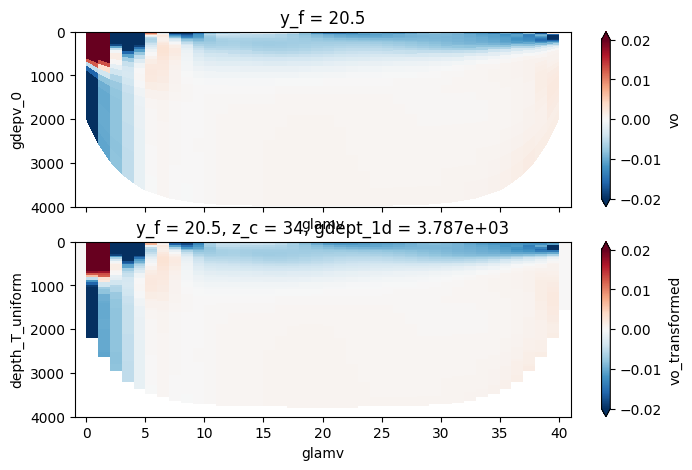

In [54]:
ds.coords['gdepv_0'] = grid.interp(ds.gdept_0, 'Y', **bd)

fig, ax = plt.subplots(2, 1, figsize=(8,5), sharex=True, sharey=True)

vmin=-0.02

ds.vo.where(ds.vmask).isel(y_f=20).plot(x='glamv', y='gdepv_0', yincrease=False, ax=ax[0], vmin=vmin)
ds.vo_transformed.where(ds.depth_T_uniform <= ds.gdepv_0.isel(z_c=-1)).isel(y_f=20).plot(x='glamv', y='depth_T_uniform', yincrease=False, ax=ax[1], vmin=vmin)

We verify that the remapping is conservative:

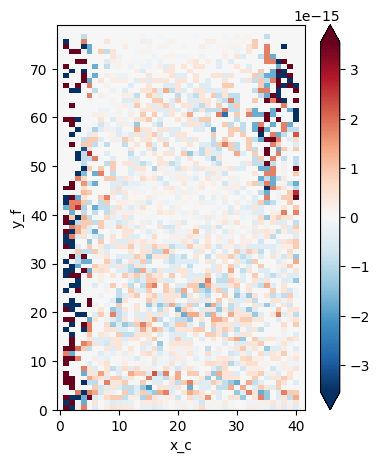

In [58]:
(grid.integrate(ds.vo.astype(np.float64), 'Z') - (ds.vo_transformed * h).sum('depth_T_uniform')).plot(robust=True)

### Compute temperature 10 meters below the MLD

Here we compute the temperature 10 meters below the MLD, using the linear interpolation. For the linear remapping, we need to provide the center value and not the bound values.
As the MLD is not the same everywhere, we cannot use the xarray interpolation tool.

In [49]:
theta_10m_below_MLD = grid.transform(
    ds.thetao.where(ds.tmask),
    'Z',
    xr.DataArray(np.array([10])),
    target_data=ds.gdept_0 - ds.mldr10_1
)
theta_10m_below_MLD

/home/romain/.local/share/virtualenvs/xgcm-examples-rCMMOxDs/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


<xarray.DataArray 'thetao' (y_c: 79, x_c: 42, dim_0: 1)>
nan nan nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan nan
Coordinates:
  * x_c      (x_c) int64 0 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 36 37 38 39 40 41
  * y_c      (y_c) int64 0 1 2 3 4 5 6 7 8 9 ... 69 70 71 72 73 74 75 76 77 78
    glamt    (y_c, x_c) float64 -0.5 0.5 1.5 2.5 3.5 ... 37.5 38.5 39.5 40.5
    gphit    (y_c, x_c) float64 -0.9999 -0.9999 -0.9999 ... 60.76 60.76 60.76
Dimensions without coordinates: dim_0

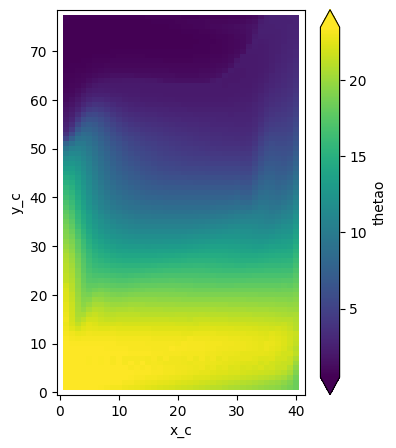

In [50]:
theta_10m_below_MLD.plot(robust=True)